In [1]:
%matplotlib inline
from math import exp,pow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### walshPercentEffectRemainingAtTime

Current Loop insulin curve.  Returns percentage of total insulin effect remaining at a specified interval after delivery; also known as Insulin On Board (IOB).

     These are 4th-order polynomial fits of John Walsh's IOB curve plots, and they first appeared in GlucoDyn.

     See: https://github.com/kenstack/GlucoDyn

     - parameter time:           The interval (in hours) after insulin delivery
     - parameter actionDuration: The total time of insulin effect (in hours)

     - returns: The percentage of total insulin effect remaining

In [2]:

def walsh_percent_effect_remaining_at_time(time, action_duration):
    if t <= 0:
        return 1
    elif t >= action_duration:
        return 0
    
    nearest_modeled_duration = None
   
    if action_duration < 3:
        nearest_modeled_duration = 3
    elif action_duration > 6:
        nearest_modeled_duration = 6
    else: 
        nearest_modeled_duration = round(action_duration)
    
    minutes = (time*60) * nearest_modeled_duration / action_duration
    
    if nearest_modeled_duration == 3:
        return -3.2030e-9 * pow(minutes, 4) + 1.354e-6 * pow(minutes, 3) - 1.759e-4 * pow(minutes, 2) + 9.255e-4 * minutes + 0.99951
    elif nearest_modeled_duration == 4:
        return -3.310e-10 * pow(minutes, 4) + 2.530e-7 * pow(minutes, 3) - 5.510e-5 * pow(minutes, 2) - 9.086e-4 * minutes + 0.99950
    elif nearest_modeled_duration == 5:
        return -2.950e-10 * pow(minutes, 4) + 2.320e-7 * pow(minutes, 3) - 5.550e-5 * pow(minutes, 2) + 4.490e-4 * minutes + 0.99300
    elif nearest_modeled_duration == 6:
        return -1.493e-10 * pow(minutes, 4) + 1.413e-7 * pow(minutes, 3) - 4.095e-5 * pow(minutes, 2) + 6.365e-4 * minutes + 0.99700
    else:
        raise Exception('Invalid!')
    

### Scalable Exponential Model 

An exponential model, as described here: https://github.com/LoopKit/Loop/issues/388

Allows us to specify time of peak activity, as well as duration, and provides activity and IOB decay functions

Many thanks to Dragan Maksimovic (@dm61) for creating such a flexible way of adjusting an insulin curve for use in closed loop systems.

In [3]:
def scalable_exp_ia(t, tp, td):
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*(tau/td)
    S = 1/(1-a+(1+a)*exp(-td/tau))
    return (S/pow(tau,2))*t*(1-t/td)*exp(-t/tau)

def scalable_exp_iob(t, tp, td):
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*tau/td
    S = 1/(1-a+(1+a)*exp(-td/tau))
    return 1-S*(1-a)*((pow(t,2)/(tau*td*(1-a)) - t/tau - 1)*exp(-t/tau)+1)

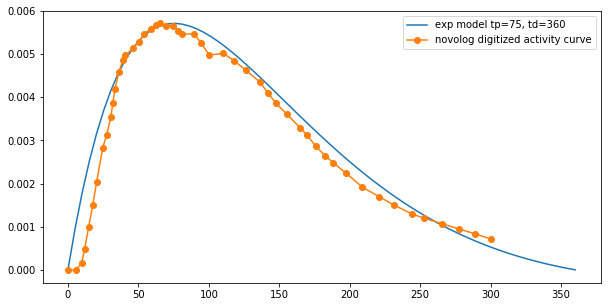

In [4]:
# params
td = float(360) # duration
tp = float(75) # activity peak

# Plot exp model
plt.figure(figsize=(10,5))
x = np.linspace(0,int(td),num=int(td/5))
y = np.array([scalable_exp_ia(t, tp=tp, td=td) for t in x])
plt.plot(x, y, label="exp model tp=%0.0f, td=%0.0f" % (tp, td))

# Novolog data
novolog_digitized = pd.read_csv('novolog_data.csv', index_col='time')
scale = y.max() / novolog_digitized.max()
plt.plot(novolog_digitized * scale, label="novolog digitized activity curve", marker='o')
plt.legend(loc='upper right')

### Compare existing Loop curve to exponential model

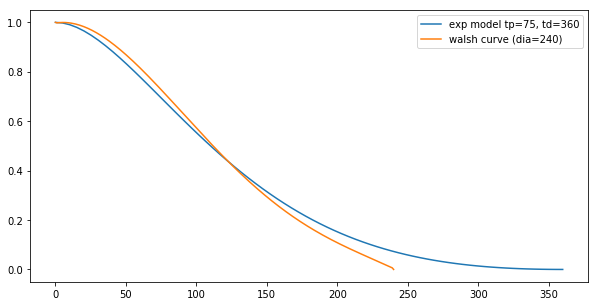

In [5]:
plt.figure(figsize=(10,5))

# params
td = float(360) # duration
tp = float(75) # activity peak

x = np.linspace(0,int(td),num=int(td/5))
new_iob = np.array([scalable_exp_iob(t, tp=tp, td=td) for t in x])
plt.plot(x, new_iob, label="exp model tp=%0.0f, td=%0.0f" % (tp, td))

dia = float(4 * 60)
x = np.linspace(0, int(dia),num=int(dia))
loop_iob = np.array([walsh_percent_effect_remaining_at_time(t, dia) for t in x])
plt.plot(x, loop_iob, label="walsh curve (dia=%0.0f)" % dia)

plt.legend(loc='upper right')
